# Grid search and training of SVM model for predicting whether player has selected equilibrium strategy.

#1. Setup

In [26]:
import pandas as pd
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import os
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.io import imread
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, confusion_matrix, RocCurveDisplay
import pickle

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# Define paths

pathtoValData = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/Val_SVM_EQ/'
pathtoTrainData = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Images/Train_SVM_EQ/'
pathtoSave = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Models_performance/SVM/EQ/'
pathtoModel = '/content/drive/Shareddrives/Eye_Tracking_NN_SD/Image_processing/Publishable_material/Saved_models/SVM/'

#2. Input Pipeline

In [11]:
def load_dataset(pathtoTrainData, pathtoValData):
  df_train = pd.read_pickle(pathtoTrainData + 'svm_df.pkl')
  x_train=df_train.iloc[:,:-1]
  y_train=df_train.iloc[:,-1]
  df_val = pd.read_pickle(pathtoValData + 'svm_df.pkl')
  x_val=df_val.iloc[:,:-1]
  y_val=df_val.iloc[:,-1]
  return x_train, y_train, x_val, y_val

x_train, y_train, x_val, y_val = load_dataset(pathtoTrainData, pathtoValData)

#3. Parameter Grid Search for SVC model

In [5]:
# defining parameter range
param_grid = {'C': [0.1, 10, 100],
              'gamma': [10, 0.1, 0.0001],
              'kernel': ['rbf']}
svc=svm.SVC(probability=False)
grid = GridSearchCV(svc, param_grid)
 
# fitting the model for grid search
grid.fit(x_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 10, 100], 'gamma': [10, 0.1, 0.0001],
                         'kernel': ['rbf']})

In [6]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
SVC(C=10, gamma=0.0001)


In [7]:
grid_predictions = grid.predict(x_val)
 
# print classification report
print(classification_report(y_val, grid_predictions))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       231
           1       0.71      0.73      0.72       249

    accuracy                           0.71       480
   macro avg       0.71      0.71      0.71       480
weighted avg       0.71      0.71      0.71       480



#4. Refit model with best parameter and save it

In [12]:
# refit model with best parameter and save it:
svc=svm.SVC(C=10, kernel='rbf', gamma= 0.0001, probability=False)
print("The training of the model is started, please wait for while as it may take few minutes to complete")
svc.fit(x_train,y_train)

The training of the model is started, please wait for while as it may take few minutes to complete


SVC(C=10, gamma=0.0001)

In [13]:
pickle.dump(svc,open(pathtoModel + 'svm_model_EQ.p','wb'))
print("Pickle is dumped successfully")

Pickle is dumped successfully


#5. Model Performance

In [14]:
y_preds=svc.predict(x_val)
print(classification_report(y_val, y_preds))
print(confusion_matrix(y_preds,y_val))

              precision    recall  f1-score   support

           0       0.70      0.68      0.69       231
           1       0.71      0.73      0.72       249

    accuracy                           0.71       480
   macro avg       0.71      0.71      0.71       480
weighted avg       0.71      0.71      0.71       480

[[158  67]
 [ 73 182]]


In [25]:
cls = classification_report(y_val, y_preds, output_dict=True)
clsf_report = pd.DataFrame(cls).transpose()
clsf_report.to_csv(pathtoSave + 'classification_report_EQ_val.csv', index= True)

In [17]:
macro = roc_auc_score(y_val, y_preds,average='macro')
weighted = roc_auc_score(y_val, y_preds,average='weighted')
roc = {'macro':  [macro],
        'weighted': [weighted],
        }

roc = pd.DataFrame(roc)
roc.to_csv(pathtoSave + 'roc_report_val.csv', index= True)

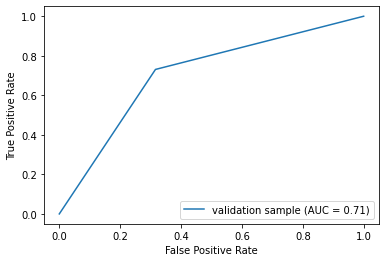

In [24]:
fpr, tpr , threshold = roc_curve (y_val, y_preds, pos_label = 1, drop_intermediate = False)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc(fpr, tpr), estimator_name='validation sample')
display.plot()
plt.savefig(pathtoSave + 'roc_curve_val.png')